In [1]:
# Dependencies
import csv as csv
import http.client 
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pprint
import psycopg2
import requests
import sqlalchemy
from bs4 import BeautifulSoup as bs
from dotenv import load_dotenv
from functools import reduce
from selenium import webdriver
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sodapy import Socrata
from splinter import Browser
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, Float, Date

In [2]:
# Loading homeowrk7.env so that the environment variables can be used in the engine object url
load_dotenv("project3.env")
# Initializing variables to hold each environmet varaible
username=os.environ.get("USERNAME")
password=os.environ.get("PASSWORD")
host=os.environ.get("HOST")
port=os.environ.get("PORT")
database=os.environ.get("DATABASE")
google_key = os.environ.get('GOOGLE_API_KEY')
yelp_client_id = os.environ.get('YELP_CLIENT_ID')
yelp_key = os.environ.get('YELP_API_KEY')
sf_data_key = os.environ.get('SFDATAAPPTOKEN')
acs_5yr_key = os.environ.get('ACS_5YR_KEY')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
hist_complete_data = pd.read_csv("../data/complete_data/other_hist_complete_data.csv")
complete_data = pd.read_csv("../data/complete_data/other_complete_data.csv")
complete_nocoffee_data = pd.read_csv("../data/complete_data/other_complete_nocoffee_data.csv")

In [5]:
complete_data.columns

Index(['year', 'zip_code', 'pct_wht', 'pct_25_34', 'pct_college_deg', 'pct_chng_pct_25_34', 'pct_chng_pct_college_deg', 'pct_chng_pct_wht', 'num_coffee_shops', 'pct_chng_housing_price', 'current_year_housing_price', 'next_year_housing_price'], dtype='object')

In [6]:
complete_data = complete_data[complete_data["pct_chng_pct_25_34"] != 0]

In [7]:
complete_data

,year,zip_code,pct_wht,pct_25_34,pct_college_deg,pct_chng_pct_25_34,pct_chng_pct_college_deg,pct_chng_pct_wht,num_coffee_shops,pct_chng_housing_price,current_year_housing_price,next_year_housing_price
139,2012,90001,69.799927,16.455580,1.941997,-5.156556,-10.635496,-5.340796,0,13.279825,1.827333e+05,2.070000e+05
140,2012,90004,34.245595,17.684944,22.762547,1.529618,8.698472,-4.838120,0,18.204211,6.969083e+05,8.237750e+05
141,2012,90007,35.688269,15.428493,8.221657,-3.193995,0.256301,2.275880,1,14.994363,3.252333e+05,3.740000e+05
142,2012,90010,20.234681,22.737940,41.199478,33.008711,0.630194,-8.362155,1,0.000000,0.000000e+00,0.000000e+00
143,2012,90012,27.787683,19.098889,16.119188,7.566177,6.293039,6.728310,1,17.350815,2.961917e+05,3.475833e+05
144,2012,90013,34.202619,15.636403,26.797596,12.989168,16.184195,-7.745005,0,0.000000,0.000000e+00,0.000000e+00
145,2012,90014,41.774658,19.528438,27.591793,11.554325,42.025409,11.944037,1,0.000000,0.000000e+00,0.000000e+00
146,2012,90015,34.712475,17.410007,13.487661,-2.149768,16.778175,6.316204,1,28.265197,3.809750e+05,4.886583e+05
147,2012,90016,22.398940,15.177751,10.534642,-0.238907,12.424678,7.799641,0,19.427212,2.941750e+05,3.513250e+05
148,2012,90017,27.284105,22.515213,11.324500,2.889287,18.431435,-14.958781,0,27.707840,3.342917e+05,4.269167e+05


In [8]:
without_hist_X = complete_data[['pct_25_34', 'pct_college_deg', 'pct_wht', 'current_year_housing_price', 'num_coffee_shops']]
without_hist_y = complete_data['next_year_housing_price'].values.reshape(-1, 1)

print("Shape: ", without_hist_X.shape, without_hist_y.shape)

Shape:  (828, 5) (828, 1)


In [9]:
without_hist_X

,pct_25_34,pct_college_deg,pct_wht,current_year_housing_price,num_coffee_shops
139,16.455580,1.941997,69.799927,1.827333e+05,0
140,17.684944,22.762547,34.245595,6.969083e+05,0
141,15.428493,8.221657,35.688269,3.252333e+05,1
142,22.737940,41.199478,20.234681,0.000000e+00,1
143,19.098889,16.119188,27.787683,2.961917e+05,1
144,15.636403,26.797596,34.202619,0.000000e+00,0
145,19.528438,27.591793,41.774658,0.000000e+00,1
146,17.410007,13.487661,34.712475,3.809750e+05,1
147,15.177751,10.534642,22.398940,2.941750e+05,0
148,22.515213,11.324500,27.284105,3.342917e+05,0


In [10]:
without_hist_X_train, without_hist_X_test, without_hist_y_train, without_hist_y_test = train_test_split(without_hist_X, without_hist_y, random_state=42)

In [11]:
without_hist_data_model = LinearRegression()

In [12]:
without_hist_data_model.fit(without_hist_X_train, without_hist_y_train)
training_score = without_hist_data_model.score(without_hist_X_train, without_hist_y_train)
testing_score = without_hist_data_model.score(without_hist_X_test, without_hist_y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9821892018783923
Testing Score: 0.993365793597268


Text(0.5, 1.0, 'Residual Plot')

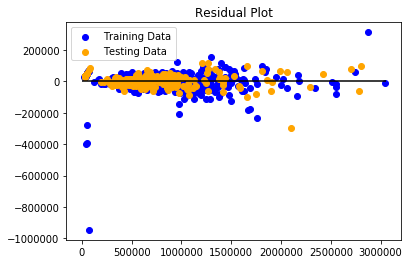

In [13]:
plt.scatter(without_hist_data_model.predict(without_hist_X_train), without_hist_data_model.predict(without_hist_X_train) - without_hist_y_train, c="blue", label="Training Data")
plt.scatter(without_hist_data_model.predict(without_hist_X_test), without_hist_data_model.predict(without_hist_X_test) - without_hist_y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=without_hist_y.min(), xmax=without_hist_y.max())
plt.title("Residual Plot")

In [14]:
joblib_file = "../models/without_hist_non_scaled_model.pkl"
joblib.dump(without_hist_data_model, joblib_file)

# Load from file
non_scaled_model_re_loaded = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = non_scaled_model_re_loaded.score(without_hist_X_train, without_hist_y_train)

print("Test score: {0:.2f} %".format(100 * score))
#Ypredict = pickle_model.predict(X_test)

Test score: 98.22 %


## Scaling

In [15]:
without_hist_X_scaler = StandardScaler().fit(without_hist_X_train)
without_hist_y_scaler = StandardScaler().fit(without_hist_y_train)

without_hist_X_train_scaled = without_hist_X_scaler.transform(without_hist_X_train)
without_hist_X_test_scaled = without_hist_X_scaler.transform(without_hist_X_test)
without_hist_y_train_scaled = without_hist_y_scaler.transform(without_hist_y_train)
without_hist_y_test_scaled = without_hist_y_scaler.transform(without_hist_y_test)

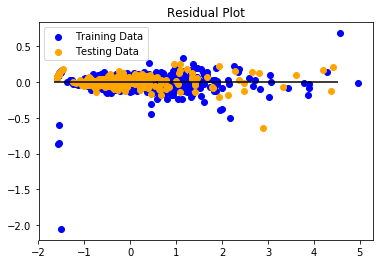

In [16]:
scaled_model = LinearRegression()
scaled_model.fit(without_hist_X_train_scaled, without_hist_y_train_scaled)
plt.scatter(scaled_model.predict(without_hist_X_train_scaled), scaled_model.predict(without_hist_X_train_scaled) - without_hist_y_train_scaled, c="blue", label="Training Data")
plt.scatter(scaled_model.predict(without_hist_X_test_scaled), scaled_model.predict(without_hist_X_test_scaled) - without_hist_y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=without_hist_y_test_scaled.min(), xmax=without_hist_y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [17]:
predictions = scaled_model.predict(without_hist_X_test_scaled)
MSE = mean_squared_error(without_hist_y_test_scaled, predictions)
r2 = scaled_model.score(without_hist_X_test_scaled, without_hist_y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.008080462212875632, R2: 0.9933657935972674


In [18]:
test_array = np.array([17.350256, 2.173119, 73.738130, 1.781167e+05, 0])
test_array.reshape(1, -1)
scaled_model.predict(test_array.reshape(1, -1))

array([[173382.20047597]])

In [19]:
test_array = np.array([17.350256, 2.173119, 73.738130, 1.781167e+05, 0])
test_array.reshape(1, -1)

array([[1.7350256e+01, 2.1731190e+00, 7.3738130e+01, 1.7811670e+05,
        0.0000000e+00]])

In [20]:
joblib_file = "../models/without_hist_scaled_model.pkl"
joblib.dump(scaled_model, joblib_file)

# Load from file
scaled_model_re_loaded = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = scaled_model_re_loaded.score(without_hist_X_train, without_hist_y_train)

print("Test score: {0:.2f} %".format(100 * score))
#Ypredict = pickle_model.predict(X_test)

Test score: 93.44 %
